In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from cnp.data import GPGenerator

from cnp.cnp import StandardConvGNP, StandardFullyConnectedTEGNP
from cnp.cov import InnerProdCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno

import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [2]:
plot_grid_res = 100
num_samples = 50
xmin = -4.5
xmax = 4.5
ymin = -5
ymax = 5
num_basis_dim = 512

In [3]:
kernel = stheno.EQ().stretch(1.)
std_noise = 1e-1

gen_params = {
    'batch_size'                : 1,
    'x_range'                   : [-3, 3],
    'max_num_context'           : 4,
    'max_num_target'            : 10,
    'include_context_in_target' : False,
    'device'                    : 'cpu'
}

gen = GPGenerator(iterations_per_epoch=1,
                  kernel=kernel,
                  std_noise=std_noise,
                  **gen_params)

seed = 3

# Mean field ConvGNP

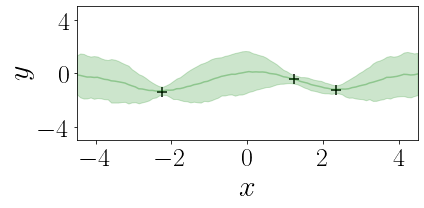

In [49]:
mean_field_cov = MeanFieldCov(num_basis_dim=1)
add_no_noise = AddNoNoise()

mean_field_conv_gnp_path = './models/meanfield-convGNP'

model = StandardConvGNP(covariance=mean_field_cov,
                        add_noise=add_no_noise)
model.load_state_dict(torch.load(mean_field_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])


np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

std_dev = np.diag(cov[0]) ** 0.5


plt.figure(figsize=(6, 3))
plt.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context')

# plt.scatter(x_target[0, :, 0], y_target[0, :, 0], marker='+', color='red')
plt.fill_between(x_plot[0, :, 0],
                 mean[0, :, 0] - 2 * std_dev,
                 mean[0, :, 0] + 2 * std_dev,
                 color='green',
                 alpha=0.2)

plt.plot(x_plot[0, :, 0],
         mean[0, :, 0],
         color='green',
         alpha=0.3)

# plt.title('ConvCNP', fontsize=25)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xticks(np.linspace(-4, 4, 5), fontsize=26)
plt.yticks(np.linspace(-4, 4, 3), fontsize=26)
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$y$', fontsize=30)
plt.tight_layout()
plt.savefig('./plots/meanfield-convGNP.pdf')
plt.show()

# Inner product convGNP

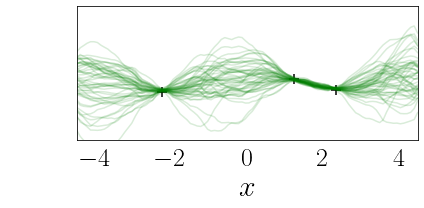

In [59]:
inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(covariance=inner_prod_cov,
                        add_noise=add_homo_noise)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])


np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

chol = np.linalg.cholesky(cov[0] + 1e-4 * np.eye(cov[0].shape[0]))

samples = np.random.normal(size=(chol.shape[0], num_samples))
samples = mean[:, :, 0] + (chol @ samples).T

plt.figure(figsize=(6, 3))
plt.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context')

# plt.plot(x_plot[0, :, 0],
#          mean[0, :, 0],
#          color='blue',
#          alpha=0.3)

plt.plot(x_plot_rep.T,
         samples.T,
         color='green',
         alpha=0.15,
         zorder=1)

# plt.title('ConvGNP', fontsize=25)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xticks(np.linspace(-4, 4, 5), fontsize=26)
plt.yticks(np.linspace(-4, 4, 5), fontsize=26, color='white')
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$y$', fontsize=30, color='white')
plt.gca().tick_params(which='major', color='white')
plt.tight_layout()
plt.savefig('./plots/innerprod-convGNP.pdf')
plt.show()

# Innerprod TEGNP

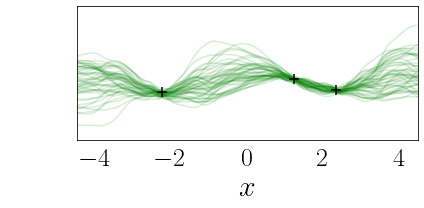

In [62]:
inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-TEGNP'

model = StandardFullyConnectedTEGNP(covariance=inner_prod_cov,
                                    add_noise=add_homo_noise)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])

np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

chol = np.linalg.cholesky(cov[0] + 1e-4 * np.eye(cov[0].shape[0]))

samples = np.random.normal(size=(chol.shape[0], num_samples))
samples = mean[:, :, 0] + (chol @ samples).T

plt.figure(figsize=(6, 3))
plt.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context',
            zorder=2)

plt.plot(x_plot_rep.T,
         samples.T,
         color='green',
         alpha=0.15,
         zorder=1)

# plt.title('TEGNP', fontsize=25)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xticks(np.linspace(-4, 4, 5), fontsize=26)
plt.yticks(np.linspace(-4, 4, 5), fontsize=26, color='white')
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$y$', fontsize=30, color='white')
plt.gca().tick_params(which='major', color='white')
plt.tight_layout()
plt.savefig('./plots/innerprod-TEGNP.pdf')
plt.show()